In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, ndcg_score
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cell 2: Load your dataset
# Assuming your dataset is in a CSV file named 'books.csv'
books_df = pd.read_csv('Book.csv', encoding='Windows-1254')

In [3]:
import chardet

with open('Book.csv', 'rb') as file:
    raw_data = file.read()
    result = chardet.detect(raw_data)
    print(result)

{'encoding': 'Windows-1254', 'confidence': 0.5337092376516288, 'language': 'Turkish'}


In [4]:
def inspect_line(filename, line_number):
    with open(filename, 'rb') as file:
        # Skip to the desired line
        for _ in range(line_number - 1):
            file.readline()
        
        # Read the problematic line
        problematic_line = file.readline()
        
        # Print raw bytes
        print("Raw bytes:", problematic_line)
        
        # Try decoding with different encodings
        encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
        for encoding in encodings:
            try:
                decoded_line = problematic_line.decode(encoding)
                print(f"\nDecoded with {encoding}:")
                print(decoded_line)
            except UnicodeDecodeError:
                print(f"Cannot decode with {encoding}")

# Use the function
inspect_line('Book.csv', 9035)

Raw bytes: b'"41967.Evening_Class","Evening Class","","Maeve Binchy","4.00","Among the many evening classes starting all over Dublin is an \'Introduction to Italian\'. On the surface it could be just one of hundreds in which some students will succeed and some will fall along the way. the hopes and dreams of so many people are tied up in the twice weekly lessons. they are ready to set off on the promised trip to Italy at the end of the year, everyone\'s destiny has changed utterly.","English","9780752876825","[\'Fiction\', \'Chick Lit\', \'Romance\', \'Ireland\', \'Contemporary\', \'Irish Literature\', \'Adult Fiction\', \'Drama\', \'Novels\', \'Womens Fiction\']","[]","Paperback","","528","Orion Publishing Group","June 30th 2005","10/28/96","[]","39596","[\'12876\', \'15563\', \'9586\', \'1328\', \'243\']","96","[\'Dublin (Ireland)\']","https://i.gr-assets.com/images/S/compressed.photo.goodreads.com/books/1368673760l/41967.jpg","342","6","2.86"\r\n'

Decoded with utf-8:
"41967.Evening

In [5]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52478 entries, 0 to 52477
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            52478 non-null  object 
 1   title             52478 non-null  object 
 2   series            23470 non-null  object 
 3   author            52478 non-null  object 
 4   rating            52478 non-null  float64
 5   description       51140 non-null  object 
 6   language          48672 non-null  object 
 7   isbn              52478 non-null  object 
 8   genres            52478 non-null  object 
 9   characters        52478 non-null  object 
 10  bookFormat        51005 non-null  object 
 11  edition           4955 non-null   object 
 12  pages             50131 non-null  object 
 13  publisher         48782 non-null  object 
 14  publishDate       51598 non-null  object 
 15  firstPublishDate  31152 non-null  object 
 16  awards            52478 non-null  object

In [17]:
books_df["pages"].head()

0    374
1    870
2    324
3    279
4    501
Name: pages, dtype: object

In [33]:
import pandas as pd

# Assuming you already have your DataFrame 'books_df'
# Step 1: Expand genres into individual rows
expanded_books_df = books_df.explode('genres')

# Step 2: Get sorted unique genres
unique_genres = sorted(expanded_books_df['genres'].unique())

# Step 3: Create a DataFrame for unique genres
unique_genres_df = pd.DataFrame(unique_genres, columns=['Genre'])

# Step 4: Save the unique genres DataFrame to a CSV file
unique_genres_df.to_csv('unique_genres.csv', index=False)

print("Unique genres have been saved to 'unique_genres.csv'.")


Unique genres have been saved to 'unique_genres.csv'.


In [31]:

# Expand genres into individual rows
expanded_books_df = books_df.explode('genres')

unique_genres = sorted(expanded_books_df['genres'].unique())

# Create a DataFrame for unique genres
unique_genres_df = pd.DataFrame(unique_genres, columns=['Genre'])

# Print unique genres in CSV format
csv_output = unique_genres_df.to_csv(index=False)
print(csv_output)
# Print unique genres with numbering
print("Unique Genres:")
for i, genre in enumerate(unique_genres, start=1):
    print(f"{i}. {genre}")

Genre
""
'10th Century'
'11th Century'
'12th Century'
'13th Century'
'14th Century'
'15th Century'
'16th Century'
'17th Century'
'18th Century'
'19th Century'
'1st Grade'
'20th Century'
'21st Century'
'2nd Grade'
'40k'
'Abuse'
'Academia'
'Academic'
'Academics'
'Action'
'Activism'
'Adolescence'
'Adoption'
'Adult Fiction'
'Adult'
'Adventure'
'Aeroplanes'
'Africa'
'African American Literature'
'African American Romance'
'African American'
'African Literature'
'Agriculture'
'Aircraft'
'Airships'
'Albanian Literature'
'Alchemy'
'Alcohol'
'Alexandria'
'Algebra'
'Algeria'
'Algorithms'
'Aliens'
'Alternate History'
'Alternate Universe'
'Alternative Medicine'
'Amateur Sleuth'
'Amazon'
'American Civil War'
'American Classics'
'American Fiction'
'American History'
'American Revolution'
'American Revolutionary War'
'American'
'Americana'
'Amish Fiction'
'Amish'
'Anarchism'
'Ancient History'
'Ancient'
'Angels'
'Anglo Saxon'
'Angola'
'Animal Fiction'
'Animals'
'Anime'
'Anthologies'
'Anthropology'
'An

In [30]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52478 entries, 0 to 52477
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            52478 non-null  object 
 1   title             52478 non-null  object 
 2   series            23470 non-null  object 
 3   author            52478 non-null  object 
 4   rating            52478 non-null  float64
 5   description       51140 non-null  object 
 6   language          48672 non-null  object 
 7   isbn              52478 non-null  object 
 8   genres            52478 non-null  object 
 9   characters        52478 non-null  object 
 10  bookFormat        51005 non-null  object 
 11  edition           4955 non-null   object 
 12  pages             50131 non-null  object 
 13  publisher         48782 non-null  object 
 14  publishDate       51598 non-null  object 
 15  firstPublishDate  31152 non-null  object 
 16  awards            52478 non-null  object

### Identifying optimal no of clusters using elbow and silohoeutte method

Analyzing 59 different cluster sizes...
Progress: 5/59 clusters analyzed
Progress: 10/59 clusters analyzed
Progress: 15/59 clusters analyzed
Progress: 20/59 clusters analyzed
Progress: 25/59 clusters analyzed
Progress: 30/59 clusters analyzed
Progress: 35/59 clusters analyzed
Progress: 40/59 clusters analyzed
Progress: 45/59 clusters analyzed
Progress: 50/59 clusters analyzed
Progress: 55/59 clusters analyzed


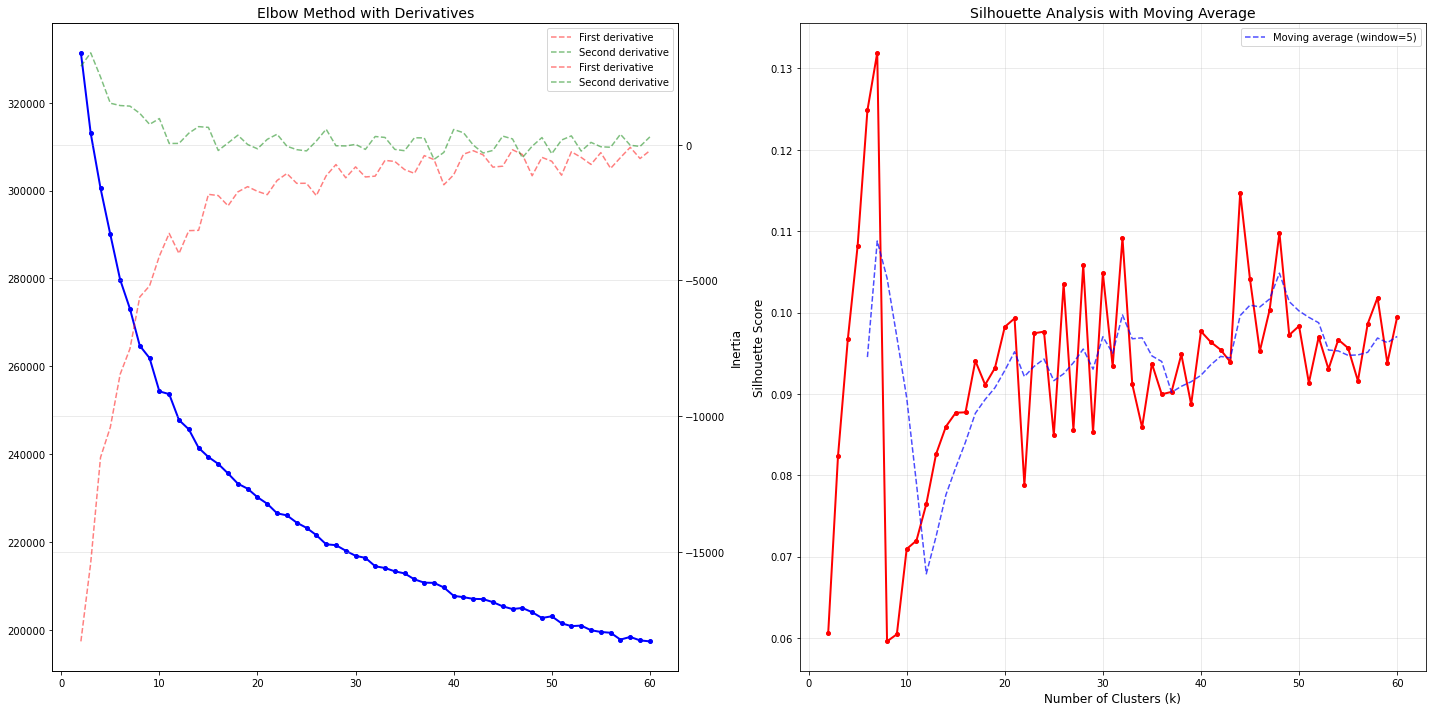


Potential optimal k values:
Based on elbow method (maximum curvature): 3
Based on silhouette score (maximum value): 7

Analyzing clusters using both potential optimal k values...

Detailed Analysis for k=3 clusters:

Cluster 1 (Size: 21621 books)
Average genres per book: 8.99
Top genres:
  - Fiction: 19770 books (91.4%)
  - Contemporary: 9503 books (44.0%)
  - Romance: 8883 books (41.1%)
  - Novels: 6404 books (29.6%)
  - Historical Fiction: 6113 books (28.3%)

Cluster 2 (Size: 16802 books)
Average genres per book: 4.73
Top genres:
  - Nonfiction: 8251 books (49.1%)
  - History: 3685 books (21.9%)
  - Biography: 3153 books (18.8%)
  - Memoir: 2296 books (13.7%)
  - Philosophy: 2163 books (12.9%)

Cluster 0 (Size: 14055 books)
Average genres per book: 9.52
Top genres:
  - Fantasy: 13816 books (98.3%)
  - Fiction: 11855 books (84.3%)
  - Young Adult: 7062 books (50.2%)
  - Romance: 5996 books (42.7%)
  - Paranormal: 5632 books (40.1%)

Detailed Analysis for k=7 clusters:

Cluster 0 (Siz

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from collections import Counter

# Read the dataset
df = pd.read_csv('Book.csv')

# Convert string representation of list to actual list
df['genres'] = df['genres'].apply(eval)

# Create binary features for genres using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(df['genres'])

# Convert to DataFrame for better visualization
genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)

# Function to find optimal clusters using elbow method and silhouette score
def find_optimal_clusters(data, max_clusters=60):
    inertias = []
    silhouette_scores = []
    k_values = range(2, max_clusters + 1)
    
    # Create a progress counter
    total_iterations = len(k_values)
    print(f"Analyzing {total_iterations} different cluster sizes...")
    
    for idx, k in enumerate(k_values, 1):
        # Changed n_init from 'auto' to 10
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
        
        # Print progress every 10%
        if idx % (total_iterations // 10) == 0:
            print(f"Progress: {idx}/{total_iterations} clusters analyzed")
    
    # Create subplot with larger figure size
    plt.figure(figsize=(20, 10))
    
    # Inertia plot (Elbow method)
    plt.subplot(1, 2, 1)
    plt.plot(k_values, inertias, 'b-', linewidth=2, label='Inertia')
    plt.plot(k_values, inertias, 'bo', markersize=4)
    
    # Add first and second derivatives to help identify elbow point
    first_derivative = np.gradient(inertias)
    second_derivative = np.gradient(first_derivative)
    
    # Plot derivatives on secondary axis
    ax2 = plt.gca().twinx()
    ax2.plot(k_values, first_derivative, 'r--', label='First derivative', alpha=0.5)
    ax2.plot(k_values, second_derivative, 'g--', label='Second derivative', alpha=0.5)
    
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Inertia', fontsize=12)
    plt.title('Elbow Method with Derivatives', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Add legends for both axes
    lines1, labels1 = plt.gca().get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Silhouette score plot
    plt.subplot(1, 2, 2)
    plt.plot(k_values, silhouette_scores, 'r-', linewidth=2)
    plt.plot(k_values, silhouette_scores, 'ro', markersize=4)
    
    # Add moving average to smooth the curve
    window_size = 5
    moving_avg = np.convolve(silhouette_scores, np.ones(window_size)/window_size, mode='valid')
    plt.plot(k_values[window_size-1:], moving_avg, 'b--', 
             label=f'Moving average (window={window_size})', alpha=0.7)
    
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Silhouette Score', fontsize=12)
    plt.title('Silhouette Analysis with Moving Average', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Find potential optimal k values
    # From elbow method (point of maximum curvature using second derivative)
    elbow_k = k_values[np.argmax(np.abs(second_derivative))]
    
    # From silhouette score (maximum value)
    silhouette_k = k_values[np.argmax(silhouette_scores)]
    
    print("\nPotential optimal k values:")
    print(f"Based on elbow method (maximum curvature): {elbow_k}")
    print(f"Based on silhouette score (maximum value): {silhouette_k}")
    
    return k_values, inertias, silhouette_scores, elbow_k, silhouette_k

# Find optimal number of clusters
k_values, inertias, silhouette_scores, elbow_k, silhouette_k = find_optimal_clusters(genre_df)

# Function to analyze and visualize cluster characteristics
def analyze_clusters(genre_df, k, mlb):
    # Changed n_init from 'auto' to 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(genre_df)
    
    cluster_analysis = []
    
    # Analyze each cluster
    for i in range(k):
        cluster_indices = np.where(clusters == i)[0]
        cluster_genres = genre_df.iloc[cluster_indices]
        genre_sums = cluster_genres.sum()
        top_genres = genre_sums.sort_values(ascending=False)[:5]
        
        cluster_analysis.append({
            'cluster': i,
            'size': len(cluster_indices),
            'top_genres': dict(top_genres),
            'avg_genres_per_book': cluster_genres.sum(axis=1).mean()
        })
    
    # Sort clusters by size
    cluster_analysis.sort(key=lambda x: x['size'], reverse=True)
    
    # Print detailed analysis
    print(f"\nDetailed Analysis for k={k} clusters:")
    for cluster in cluster_analysis:
        print(f"\nCluster {cluster['cluster']} (Size: {cluster['size']} books)")
        print(f"Average genres per book: {cluster['avg_genres_per_book']:.2f}")
        print("Top genres:")
        for genre, count in cluster['top_genres'].items():
            percentage = (count / cluster['size']) * 100
            print(f"  - {genre}: {count} books ({percentage:.1f}%)")
    
    return cluster_analysis

# Analyze both potential optimal k values
print("\nAnalyzing clusters using both potential optimal k values...")
elbow_analysis = analyze_clusters(genre_df, elbow_k, mlb)
silhouette_analysis = analyze_clusters(genre_df, silhouette_k, mlb)

####  since optimal cluster is 7 , we divided the genre into 7 clusters using vectorizer and k-mean clustering

                                        bookId  \
0                     2767052-the-hunger-games   
1  2.Harry_Potter_and_the_Order_of_the_Phoenix   
2                   2657.To_Kill_a_Mockingbird   
3                     1885.Pride_and_Prejudice   
4                               41865.Twilight   

                                       title                 series  \
0                           The Hunger Games    The Hunger Games #1   
1  Harry Potter and the Order of the Phoenix        Harry Potter #5   
2                      To Kill a Mockingbird  To Kill a Mockingbird   
3                        Pride and Prejudice                    NaN   
4                                   Twilight   The Twilight Saga #1   

                                      author  rating  \
0                            Suzanne Collins    4.33   
1  J.K. Rowling, Mary GrandPré (Illustrator)    4.50   
2                                 Harper Lee    4.28   
3  Jane Austen, Anna Quindlen (Introduction)    

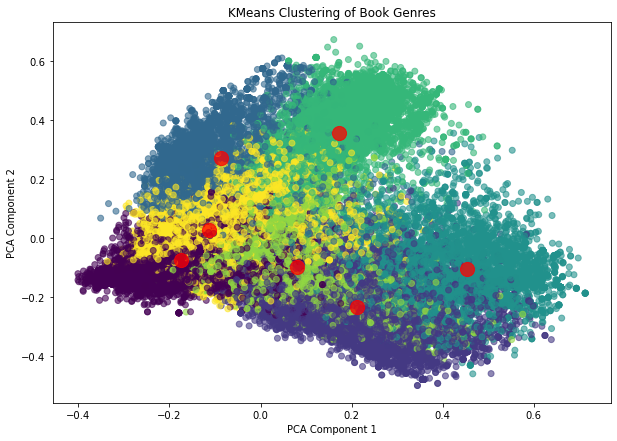


Cluster 0 Sample Genres:
['Buddhism', 'Nonfiction']
[]
['Short Stories', 'Fiction']
[]
['Fantasy', 'Forgotten Realms', 'Dungeons and Dragons', 'Epic Fantasy', 'Magic', 'Sword and Sorcery', 'Fiction']

Cluster 1 Sample Genres:
['Science Fiction', 'Fiction', 'Fantasy', 'Science Fiction Fantasy', 'Young Adult', 'Space', 'Audiobook', 'Novels', 'Aliens', 'Space Opera']
['Young Adult', 'Science Fiction', 'Fantasy', 'Fiction', 'Aliens', 'Adventure', 'Paranormal', 'Action', 'Teen', 'Supernatural']
['Horror', 'Young Adult', 'Science Fiction', 'Dystopia', 'Fiction', 'Fantasy', 'Teen', 'Action', 'Thriller', 'Dark']
['Zombies', 'Horror', 'Fiction', 'Choose Your Own Adventure', 'Humor', 'Fantasy', 'Post Apocalyptic', 'Apocalyptic', 'Science Fiction', 'Gamebooks']
['Science Fiction', 'Fiction', 'Space Opera', 'Space', 'Science Fiction Fantasy', 'Adventure', 'Aliens', 'Fantasy', 'Action', 'Audiobook']

Cluster 2 Sample Genres:
['Fiction', 'Contemporary', 'Adoption', 'Chick Lit', 'Mystery', 'Thriller

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Step 1: Load the dataset
file_path = 'Book.csv'  # Update with your dataset path
books_df = pd.read_csv(file_path)

# Check the first few rows
print(books_df.head())

# Step 2: Preprocess the genres column
# Convert genres from list-like strings to actual lists
import ast

# Safely convert the string representation of list to actual list
books_df['genres'] = books_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Flatten the list of genres into a single list
all_genres = [genre for sublist in books_df['genres'] for genre in sublist]

# Get unique genres
unique_genres = list(set(all_genres))
print(f"Total unique genres: {len(unique_genres)}")

# Step 3: Create a document for each genre (combine genres into a single document text)
# This allows us to vectorize them using TF-IDF
genre_docs = [" ".join(genre_list) for genre_list in books_df['genres']]

# Step 4: TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(genre_docs)

# Step 5: Apply KMeans Clustering
num_clusters = 7  # Choose a reasonable number of clusters; you can tune this value
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Step 6: Assign clusters to genres
books_df['genre_cluster'] = kmeans.labels_

# Display some of the clustered data
print(books_df[['title', 'genres', 'genre_cluster']].head())

# Step 7: Visualize the Clusters (Optional)
# Use PCA to reduce TF-IDF matrix to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())
reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.6)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], c='red', s=200, alpha=0.75)
plt.title('KMeans Clustering of Book Genres')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Step 8: Analyze the cluster composition
# Display sample genres for each cluster
for cluster_id in range(num_clusters):
    sample_books = books_df[books_df['genre_cluster'] == cluster_id].sample(5, replace=True)
    print(f"\nCluster {cluster_id} Sample Genres:")
    for genres in sample_books['genres']:
        print(genres)


#### use elbow method to find optimal cluster

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import ast

# Load the dataset
file_path = 'Book.csv'  # Path to your books.csv file
books_df = pd.read_csv(file_path)

# Preprocess the genres column
books_df['genres'] = books_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
genre_docs = [" ".join(genre_list) for genre_list in books_df['genres']]

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(genre_docs)

# Elbow Method to find optimal k
wcss = []
k_values = range(1, 21)  # Testing k from 1 to 20

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)  # Inertia is WCSS

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [6]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

# Enhanced turnoffs mapping with rating thresholds
turnoffs_map = {
    'Predictable plot': {
        'keywords': ['predictable', 'formulaic', 'conventional plot'],
        'genres': ['Romance', 'Contemporary Romance', 'Paranormal Romance'],
        'clusters': [5, 6],
        'min_rating': 0  # No special rating threshold
    },
    'Flat characters': {
        'keywords': ['flat', 'undeveloped characters', 'one-dimensional'],
        'genres': ['Thriller', 'Mystery Thriller', 'Action'],
        'clusters': [2],
        'min_rating': 0
    },
    'Poor writing': {
        'keywords': [],  # No keywords needed as we're using rating
        'genres': [],   # No genre restrictions
        'clusters': [], # No cluster restrictions
        'min_rating': 4.0  # Special high rating threshold for poor writing concern
    },
    'Dense writing': {
        'keywords': ['dense', 'academic', 'philosophical'],
        'genres': ['Philosophy', 'Academic', 'Literary Fiction'],
        'clusters': [0, 3],
        'min_rating': 0
    },
    'Shock ending': {
        'keywords': ['twist ending', 'shocking conclusion', 'surprise ending'],
        'genres': ['Thriller', 'Psychological Thriller', 'Horror', 'Mystery'],
        'clusters': [2],
        'min_rating': 0
    },
    'Confusing ending': {
        'keywords': ['ambiguous ending', 'open-ended', 'unclear conclusion'],
        'genres': ['Literary Fiction', 'Experimental', 'Postmodern'],
        'clusters': [3],
        'min_rating': 0
    },
    'Sad ending': {
        'keywords': ['tragic', 'heartbreaking', 'bittersweet'],
        'genres': ['Literary Fiction', 'Historical Fiction', 'War'],
        'clusters': [3],
        'min_rating': 0
    }
}

# Other mappings remain the same
characteristic_clusters = {
    'Realistic': [0],
    'World-building': [1, 6],
    'Plot-heavy': [2],
    'Character-driven': [3, 5],
    'Development': [3, 5],
    'Loveable Characters': [4, 5],
    'Quality Writing': [3],
    'Human Experience': [0, 3],
    'Woman Author': [5],
    'Unreliable Characters': [2]
}

mood_map = {
    'adventurous': [1],
    'dark': [2],
    'lighthearted': [4],
    'emotional': [3],
    'inspiring': [0],
    'mysterious': [2],
    'reflective': [0, 3],
    'tense': [2],
    'hopeful': [0, 4],
    'sad': [3, 5],
    'funny': [4],
    'challenging': [2],
    'informative': [0]
}



In [7]:
def load_and_preprocess_books(file_path):
    """Load and preprocess the books dataset"""
    books_df = pd.read_csv("Book.csv")
    
   
    # Convert string representation of lists to actual lists
    books_df['genres'] = books_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    
    # Ensure rating is numeric 
    books_df['rating'] = pd.to_numeric(books_df['rating'], errors='coerce')
    
    # Create TF-IDF matrix for genre clustering
    genre_docs = [" ".join(genre_list) for genre_list in books_df['genres']]
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(genre_docs)
    
    # Cluster books
    kmeans = KMeans(n_clusters=7, random_state=42)
    books_df['cluster'] = kmeans.fit_predict(tfidf_matrix)
    
    return books_df, vectorizer, tfidf_matrix


In [10]:
def recommend_books(books_df, vectorizer, tfidf_matrix, user_preferences, num_recommendations=10):
    """
    Enhanced recommendation function with prioritized filter application.

    Parameters:
    - user_preferences: dict with optional keys:
        - search_query: str (search term for title/author/ISBN)
        - favorite_genres: list of str
        - unwanted_genres: list of str
        - user_characteristic: str
        - min_pages: int
        - min_rating: float
        - disliked_turnoffs: list of str
        - unwanted_mood: str
    """
    # Start with all books
    filtered_books = books_df.copy()

    # 1. Apply search filter first
    if user_preferences.get('search_query'):
        query = user_preferences['search_query'].lower()
        filtered_books = filtered_books[
            filtered_books['title'].str.lower().str.contains(query, na=False) |
            filtered_books['author'].str.lower().str.contains(query, na=False) |
            filtered_books['isbn'].str.lower().str.contains(query, na=False)
        ]
    
    # 2. Apply favorite genres filter
    if user_preferences.get('favorite_genres'):
        filtered_books = filtered_books[
            filtered_books['genres'].apply(
                lambda x: any(genre in x for genre in user_preferences['favorite_genres'])
            )
        ]
    
    # 3. Apply mood, characteristic, and turnoff filters
    # Apply characteristic-based filtering
    if user_preferences.get('user_characteristic'):
        relevant_clusters = characteristic_clusters.get(user_preferences['user_characteristic'], [0])
        filtered_books = filtered_books[filtered_books['cluster'].isin(relevant_clusters)]
    
    # Apply turnoff-based filtering
    if user_preferences.get('disliked_turnoffs'):
        for turnoff in user_preferences['disliked_turnoffs']:
            if turnoff == 'Poor writing':
                filtered_books = filtered_books[filtered_books['rating'] >= 4.0]
            elif turnoff in turnoffs_map:
                turnoff_info = turnoffs_map[turnoff]

                # Filter by genres related to the turnoff
                if turnoff_info['genres']:
                    filtered_books = filtered_books[
                        ~filtered_books['genres'].apply(
                            lambda x: any(genre in x for genre in turnoff_info['genres'])
                        )
                    ]

                # Filter by clusters related to the turnoff
                if turnoff_info['clusters']:
                    filtered_books = filtered_books[
                        ~filtered_books['cluster'].isin(turnoff_info['clusters']) |
                        (filtered_books['rating'] >= turnoff_info['min_rating'])
                    ]
    
    # Apply mood-based filtering
    if user_preferences.get('unwanted_mood'):
        unwanted_mood_clusters = mood_map.get(user_preferences['unwanted_mood'], [])
        filtered_books = filtered_books[~filtered_books['cluster'].isin(unwanted_mood_clusters)]

    # 4. Apply unwanted genres filter
    if user_preferences.get('unwanted_genres'):
        filtered_books = filtered_books[
            filtered_books['genres'].apply(
                lambda x: not set(x).intersection(set(user_preferences.get('unwanted_genres', [])))
            )
        ]
    
    # 5. Apply minimum pages and rating filters
    if user_preferences.get('min_pages'):
        filtered_books['pages'] = pd.to_numeric(filtered_books['pages'], errors='coerce')
        filtered_books = filtered_books[filtered_books['pages'].fillna(0) >= user_preferences['min_pages']]
    
    if user_preferences.get('min_rating'):
        filtered_books = filtered_books[filtered_books['rating'] >= user_preferences['min_rating']]
    
    # If no books remain, try relaxing some criteria
    if filtered_books.empty:
        print("No books found with strict filters. Trying relaxed criteria...")
        filtered_books = books_df.copy()

        # Relax search and rating filter
        if user_preferences.get('search_query'):
            query = user_preferences['search_query'].lower()
            filtered_books = filtered_books[
                filtered_books['title'].str.lower().str.contains(query, na=False) |
                filtered_books['author'].str.lower().str.contains(query, na=False)
            ]

        if user_preferences.get('min_rating'):
            filtered_books = filtered_books[filtered_books['rating'] >= user_preferences['min_rating'] * 0.9]

        if 'Poor writing' in user_preferences.get('disliked_turnoffs', []):
            filtered_books = filtered_books[filtered_books['rating'] >= 4.0]

    # Calculate scores for remaining books
    if not filtered_books.empty:
        # Award score
        filtered_books['award_score'] = filtered_books['awards'].apply(
            lambda x: 1 if isinstance(x, str) and x.strip() != '[]' else 0
        )

        # Similarity score based on characteristic if provided
        if user_preferences.get('user_characteristic'):
            relevant_clusters = characteristic_clusters.get(user_preferences['user_characteristic'], [0])
            user_vector = vectorizer.transform([" ".join(map(str, relevant_clusters))])
            cosine_sim = cosine_similarity(user_vector, tfidf_matrix[filtered_books.index])
            filtered_books['similarity_score'] = cosine_sim[0]
        else:
            filtered_books['similarity_score'] = 1.0  # Default if no characteristic provided

        # Adjust weights based on poor writing concern
        if 'Poor writing' in user_preferences.get('disliked_turnoffs', []):
            filtered_books['final_score'] = (
                filtered_books['similarity_score'] * 0.3 +
                filtered_books['rating'] * 0.5 +
                filtered_books['award_score'] * 0.2
            )
        else:
            filtered_books['final_score'] = (
                filtered_books['similarity_score'] * 0.4 +
                filtered_books['rating'] * 0.3 +
                filtered_books['award_score'] * 0.3
            )
      
    # Check the number of available books
    num_available = min(len(filtered_books), num_recommendations)
    
    # Return only the available number of recommendations
    return filtered_books.nlargest(num_available, 'final_score')[
        ['bookId', 'title', 'author', 'genres', 'rating', 'pages', 'awards', 'final_score','coverImg']
    ]
    return pd.DataFrame()



Recommendations with full preferences:

Title: De que João Pessoa tem Medo? Uma abordagem em Antropologia das Emoções
Author: Mauro Guilherme Pinheiro Koury
Rating: 5.00
Score: 2.20
Displaying cover image...


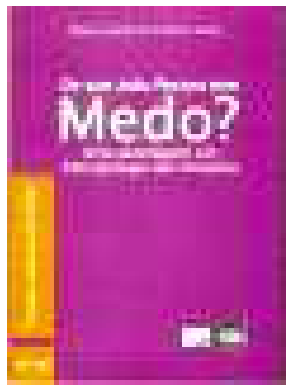


Title: Emoções, Sociedade e Cultura
Author: Mauro Guilherme Pinheiro Koury
Rating: 5.00
Score: 2.20
Displaying cover image...


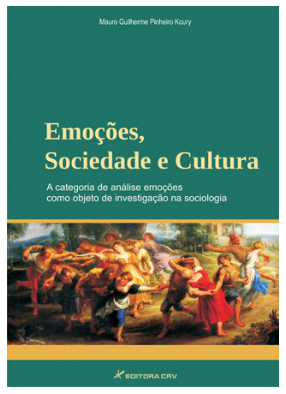


Title: You, My Love: A Diary in Verse
Author: Richard Atwood (Goodreads Author)
Rating: 5.00
Score: 2.20
Displaying cover image...


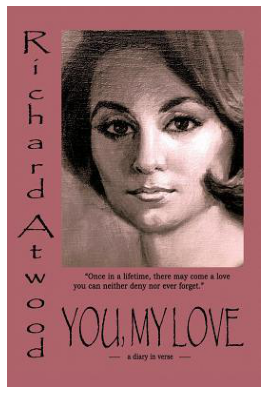


Title: Furniture Of The New Zealand Colonial Era: An Illustrated History, 1830 1900
Author: William Cottrell
Rating: 5.00
Score: 2.20
Displaying cover image...


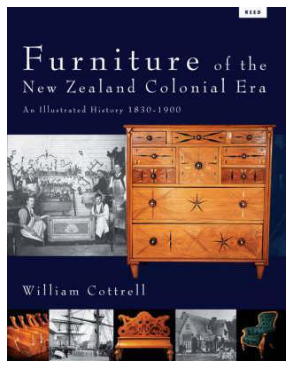


Title: Advent Journeys
Author: David Simon (Goodreads Author), Sarah Simon
Rating: 4.83
Score: 2.15
Displaying cover image...


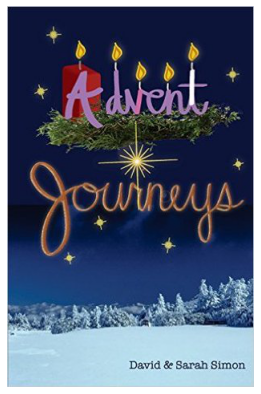


Title: Τα ποιήματα
Author: Constantinos P. Cavafy, Κ.Π. Καβάφης, Δημήτρης Δημηρούλης (Editor)
Rating: 4.81
Score: 2.14
Displaying cover image...


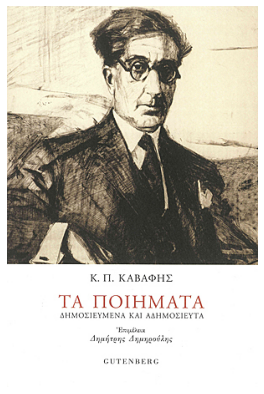


Title: За спасяването на света
Author: Kalin M. Nenov (Goodreads Author) (Anthologist, Intro, Contributor), Атанас П. Славов (Goodreads Author) (Anthologist, Intro, Contributor), Валентина Димова (Anthologist, Contributor), Вяра Крушкова (Anthologist), Дилян Благов (Anthologist), Димитър Стефанов (Anthologist), Евгения Василева (Anthologist), Александър Карапанчев (Anthologist, Contributor), more…
Rating: 4.81
Score: 2.14
Displaying cover image...


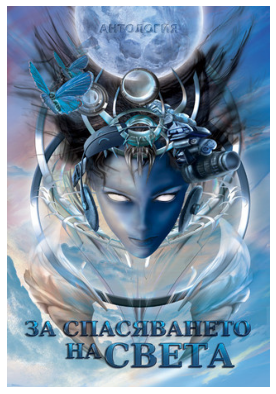


Title: Sociologia da Emoção: O Brasil urbano sob a ótica do luto
Author: Mauro Guilherme Pinheiro Koury
Rating: 4.80
Score: 2.14
Displaying cover image...


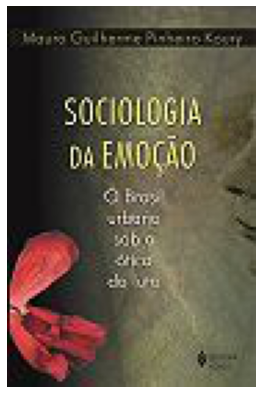


Title: PMO Governance: Practical Strategies to Govern Portfolio, Program, and Project Delivery
Author: Eugen Spivak (Goodreads Author)
Rating: 4.80
Score: 2.14
Displaying cover image...


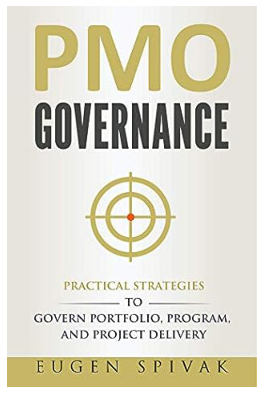


Title: Dreaming My Animal Selves/Le Songe de Mes Ames Animales
Author: Helene Cardona (Goodreads Author)
Rating: 4.79
Score: 2.14
Displaying cover image...


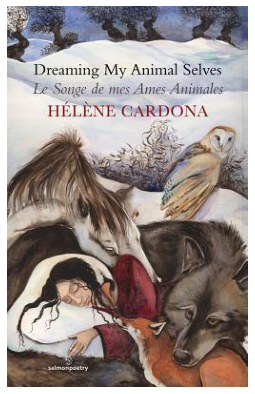


Recommendations with minimal preferences:

Title: Words of Radiance
Author: Brandon Sanderson (Goodreads Author)
Rating: 4.75
Score: 2.12
Displaying cover image...


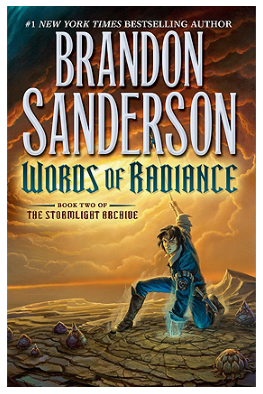


Title: The Warden and the Wolf King
Author: Andrew Peterson (Goodreads Author), Joe Sutphin (Illustrator)
Rating: 4.75
Score: 2.12
Displaying cover image...


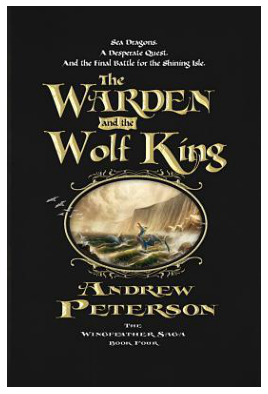


Title: Harry Potter Series Box Set
Author: J.K. Rowling
Rating: 4.73
Score: 2.12
Displaying cover image...


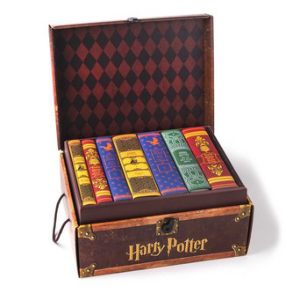


Title: The Harry Potter Collection 1-4
Author: J.K. Rowling, Mary GrandPré (Illustrator)
Rating: 4.68
Score: 2.10
Displaying cover image...


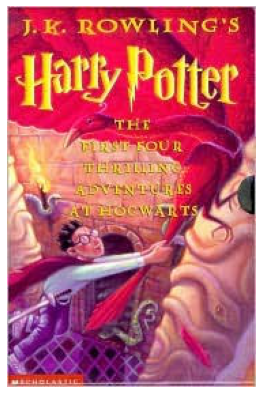


Title: Underlord
Author: Will Wight (Goodreads Author)
Rating: 4.66
Score: 2.10
Displaying cover image...


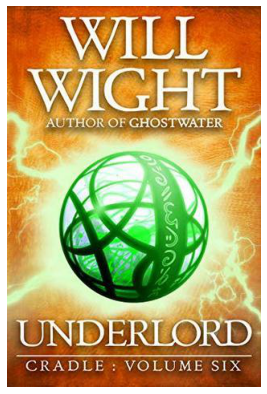


Title: The Absolute Sandman, Volume One
Author: Neil Gaiman (Goodreads Author) (Writer), Mike Dringenberg (Artist), Chris Bachalo (Artist), Michael Zulli (Artist), Kelly Jones (Goodreads Author) (Artist), Charles Vess (Artist), Colleen Doran (Artist), Malcolm Jones III (Artist), more…
Rating: 4.65
Score: 2.09
Displaying cover image...


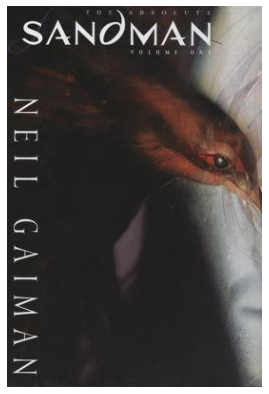


Title: Assassin's Fate
Author: Robin Hobb (Goodreads Author)
Rating: 4.64
Score: 2.09
Displaying cover image...


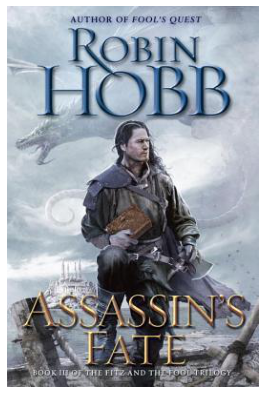


Title: A Time to Speak
Author: Nadine Brandes (Goodreads Author)
Rating: 4.64
Score: 2.09
Displaying cover image...


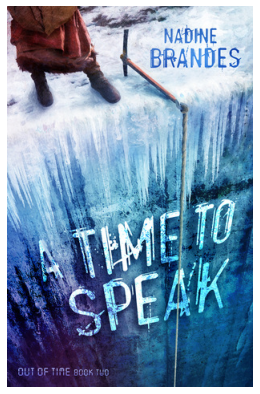


Title: The Way of Kings
Author: Brandon Sanderson (Goodreads Author)
Rating: 4.63
Score: 2.09
Displaying cover image...


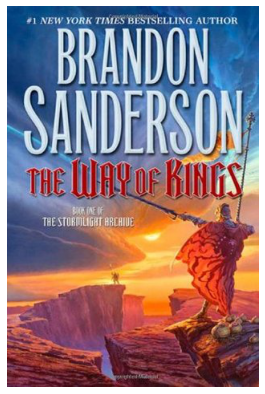


Title: The Way of Kings
Author: Brandon Sanderson (Goodreads Author)
Rating: 4.63
Score: 2.09
Displaying cover image...


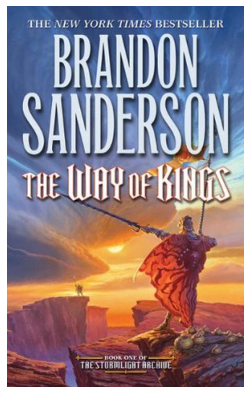

In [14]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def display_book_cover(url):
    try:
        # Fetch the image from URL
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        
        # Display the image
        plt.figure(figsize=(5, 7))  # Set figure size
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()
    except Exception as e:
        print(f"Could not display image: {e}")

def main():
    # Load and preprocess books
    books_df, vectorizer, tfidf_matrix = load_and_preprocess_books('Book.csv')
    # Example with all preferences
    full_preferences = {
        #'search_query': 'Harry Potter',
       # 'favorite_genres': ['Fantasy', 'Science Fiction'],
        #'unwanted_genres': ['Horror', 'Romance'],
       # 'user_characteristic': 'Adventure',
       # 'min_pages': 300,
        #'min_rating': 3.5,
        #'disliked_turnoffs': ['Poor writing'],
        #'unwanted_mood': 'dark'
    }

    # Example with minimal preferences
    minimal_preferences = {
        'favorite_genres': ['Fantasy'],
        'min_rating': 4.0
    }
    # Get recommendations
    full_recommendations = recommend_books(books_df, vectorizer, tfidf_matrix, full_preferences)
    minimal_recommendations = recommend_books(books_df, vectorizer, tfidf_matrix, minimal_preferences)
    
    # Print results with images
    print("\nRecommendations with full preferences:")
    if not full_recommendations.empty:
        for _, book in full_recommendations.iterrows():
            print(f"\nTitle: {book['title']}")
            print(f"Author: {book['author']}")
            print(f"Rating: {book['rating']:.2f}")
            print(f"Score: {book['final_score']:.2f}")
            
            # Display the cover image
            if 'coverImg' in book:
                print("Displaying cover image...")
                display_book_cover(book['coverImg'])
            
    print("\nRecommendations with minimal preferences:")
    if not minimal_recommendations.empty:
        for _, book in minimal_recommendations.iterrows():
            print(f"\nTitle: {book['title']}")
            print(f"Author: {book['author']}")
            print(f"Rating: {book['rating']:.2f}")
            print(f"Score: {book['final_score']:.2f}")
            
            # Display the cover image
            if 'coverImg' in book:
                print("Displaying cover image...")
                display_book_cover(book['coverImg'])

if __name__ == "__main__":
    main()

### Calculating hit ratio (Since hit ratio is 1 it indicates that book recommendation engine contains at least 1 book relevant and liked by the user)

In [ ]:
import pandas as pd

# Load the books dataset
books_df = pd.read_csv('Book.csv')  # Adjust the path to your CSV file

    # Convert string representation of lists to actual lists
books_df['genres'] = books_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    
    # Ensure rating is numeric
    
books_df['rating'] = pd.to_numeric(books_df['rating'], errors='coerce')
    
    # Create TF-IDF matrix for genre clustering
genre_docs = [" ".join(genre_list) for genre_list in books_df['genres']]
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(genre_docs)
    
    # Cluster books
kmeans = KMeans(n_clusters=7, random_state=42)
books_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

def calculate_hit_rate(books_df, vectorizer, tfidf_matrix, user_preferences_list, ground_truth, num_recommendations=10):
    """
    Calculate the Hit Rate for the book recommendation system.
    
    Parameters:
    - books_df: DataFrame containing book information
    - vectorizer: The vectorizer used for TF-IDF transformation
    - tfidf_matrix: The TF-IDF matrix for book features
    - user_preferences_list: List of dictionaries, each representing user preferences
    - ground_truth: Dictionary where keys are user IDs and values are sets of relevant book IDs
    - num_recommendations: Number of books to recommend for each user
    
    Returns:
    - hit_rate: The calculated Hit Rate
    """
    hits = 0
    total_users = len(user_preferences_list)

    # Iterate over each user's preferences
    for i, user_preferences in enumerate(user_preferences_list):
        # Generate book recommendations for the user
        recommended_books = recommend_books(books_df, vectorizer, tfidf_matrix, user_preferences, num_recommendations)
        
        if not recommended_books.empty:
            recommended_ids = set(recommended_books['bookId'].tolist())
            
            # Check if there's a hit (any overlap with ground truth)
            user_id = user_preferences.get('user_id')
            if user_id in ground_truth:
                relevant_books = ground_truth[user_id]
                if recommended_ids.intersection(relevant_books):
                    hits += 1

    # Calculate Hit Rate
    hit_rate = hits / total_users if total_users > 0 else 0
    return hit_rate

# Example usage
user_preferences_list = [
    {'user_id': 1, 'favorite_genres': ['Fantasy'], 'min_rating': 4.0},
    {'user_id': 2, 'search_query': 'Harry Potter', 'min_pages': 300},
    {'user_id': 3, 'user_characteristic': 'Adventure', 'disliked_turnoffs': ['Poor writing']}
]

# Define ground truth data (e.g., from user reading history or test set)
ground_truth = {
    1: {'17332218-words-of-radiance', '22091081-the-warden-and-the-wolf-king', '862041.Harry_Potter_Series_Box_Set'},  # Relevant book IDs for user 1 
    2: {'862041.Harry_Potter_Series_Box_Set', '99298.The_Harry_Potter_Collection_1_4', '136251.Harry_Potter_and_the_Deathly_Hallows'},  # Relevant book IDs for user 2 
    3: {'6772065-de-que-jo-o-pessoa-tem-medo-uma-abordagem-em-antropologia-das-emo-es', '4974052-you-my-love'}        # Relevant book IDs for user 3 
}

# Calculate Hit Rate
hit_rate = calculate_hit_rate(books_df, vectorizer, tfidf_matrix, user_preferences_list, ground_truth, num_recommendations=10)
print(f"Hit Rate: {hit_rate:.4f}")


### Generating 100 random user preference

In [15]:
import random
from typing import List, Dict
import numpy as np

class PreferenceGenerator:
    def __init__(self):
        # Cluster-based characteristic mappings
        self.characteristic_clusters = {
            'Realistic': [0],
            'World-building': [1, 6],
            'Plot-heavy': [2],
            'Character-driven': [3, 5],
            'Development': [3, 5],
            'Loveable Characters': [4, 5],
            'Quality Writing': [3],
            'Human Experience': [0, 3],
            'Woman Author': [5],
            'Unreliable Characters': [2]
        }

        # Mood mappings
        self.mood_map = {
            'adventurous': [1],
            'dark': [2],
            'lighthearted': [4],
            'emotional': [3],
            'inspiring': [0],
            'mysterious': [2],
            'reflective': [0, 3],
            'tense': [2],
            'hopeful': [0, 4],
            'sad': [3, 5],
            'funny': [4],
            'challenging': [2],
            'informative': [0]
        }

        # Genre clusters (mapping genres to their primary clusters)
        self.genre_clusters = {
            'Romance': [5, 6],
            'Contemporary Romance': [5],
            'Paranormal Romance': [6],
            'Fantasy': [1, 6],
            'Science Fiction': [1, 6],
            'Mystery': [2],
            'Thriller': [2],
            'Mystery Thriller': [2],
            'Psychological Thriller': [2],
            'Horror': [2],
            'Historical Fiction': [0, 3],
            'Literary Fiction': [3],
            'Contemporary': [0, 5],
            'Young Adult': [4, 6],
            'Non-Fiction': [0],
            'Biography': [0, 3],
            'Philosophy': [0, 3],
            'Classic': [3],
            'Adventure': [1],
            'Crime': [2],
            'Drama': [3, 5],
            'Dystopian': [1, 2],
            'War': [0, 2],
            'Action': [2],
            'Academic': [0],
            'Experimental': [3],
            'Postmodern': [3]
        }

        # Turnoff mappings
        self.turnoffs_map = {
            'Predictable plot': {
                'genres': ['Romance', 'Contemporary Romance', 'Paranormal Romance'],
                'clusters': [5, 6],
                'min_rating': 0
            },
            'Flat characters': {
                'genres': ['Thriller', 'Mystery Thriller', 'Action'],
                'clusters': [2],
                'min_rating': 0
            },
            'Poor writing': {
                'genres': [],
                'clusters': [],
                'min_rating': 4.0
            },
            'Dense writing': {
                'genres': ['Philosophy', 'Academic', 'Literary Fiction'],
                'clusters': [0, 3],
                'min_rating': 0
            },
            'Shock ending': {
                'genres': ['Thriller', 'Psychological Thriller', 'Horror', 'Mystery'],
                'clusters': [2],
                'min_rating': 0
            },
            'Confusing ending': {
                'genres': ['Literary Fiction', 'Experimental', 'Postmodern'],
                'clusters': [3],
                'min_rating': 0
            },
            'Sad ending': {
                'genres': ['Literary Fiction', 'Historical Fiction', 'War'],
                'clusters': [3],
                'min_rating': 0
            }
        }

        # Common search terms by cluster
        self.cluster_search_terms = {
            0: ['To Kill a Mockingbird', '1984', 'The Catcher in the Rye'],
            1: ['The Lord of the Rings', 'Dune', 'The Name of the Wind'],
            2: ['Gone Girl', 'The Da Vinci Code', 'The Girl with the Dragon Tattoo'],
            3: ['Pride and Prejudice', 'The Great Gatsby', 'Normal People'],
            4: ['The Hitchhiker\'s Guide to the Galaxy', 'Good Omens'],
            5: ['Little Women', 'The Handmaid\'s Tale', 'Jane Eyre'],
            6: ['Harry Potter', 'A Game of Thrones', 'The Way of Kings']
        }

    def get_cluster_based_search_term(self, characteristic=None):
        """Get a search term that aligns with user characteristics"""
        if characteristic and characteristic in self.characteristic_clusters:
            possible_clusters = self.characteristic_clusters[characteristic]
            cluster = random.choice(possible_clusters)
            if cluster in self.cluster_search_terms:
                return random.choice(self.cluster_search_terms[cluster])
        return random.choice([term for terms in self.cluster_search_terms.values() for term in terms])

    def get_compatible_genres(self, characteristic=None, unwanted_mood=None):
        """Get genres that are compatible with the given characteristic and mood"""
        compatible_genres = set(self.genre_clusters.keys())
        
        if characteristic:
            char_clusters = set(self.characteristic_clusters.get(characteristic, []))
            compatible_genres = {
                genre for genre, clusters in self.genre_clusters.items()
                if any(c in char_clusters for c in clusters)
            }
        
        if unwanted_mood:
            unwanted_clusters = set(self.mood_map.get(unwanted_mood, []))
            compatible_genres = {
                genre for genre in compatible_genres
                if not any(c in unwanted_clusters for c in self.genre_clusters.get(genre, []))
            }
        
        return list(compatible_genres) if compatible_genres else list(self.genre_clusters.keys())

    def generate_preferences(self, num_users: int = 100) -> List[Dict]:
        """Generate cluster-aware user preferences"""
        user_preferences = []

        for user_id in range(num_users):
            preferences = {'user_id': user_id}

            # Select characteristic (70% chance)
            if random.random() < 0.7:
                preferences['user_characteristic'] = random.choice(list(self.characteristic_clusters.keys()))

            # Select unwanted mood (40% chance)
            if random.random() < 0.4:
                preferences['unwanted_mood'] = random.choice(list(self.mood_map.keys()))

            # Get compatible genres
            available_genres = self.get_compatible_genres(
                preferences.get('user_characteristic'),
                preferences.get('unwanted_mood')
            )

            # Add favorite genres (80% chance, 1-4 genres)
            if random.random() < 0.8 and available_genres:
                num_genres = random.randint(1, min(4, len(available_genres)))
                preferences['favorite_genres'] = random.sample(available_genres, num_genres)

            # Add unwanted genres (60% chance, 1-3 genres)
            if random.random() < 0.6 and available_genres:
                unwanted_candidates = [g for g in available_genres if g not in preferences.get('favorite_genres', [])]
                if unwanted_candidates:
                    num_genres = random.randint(1, min(3, len(unwanted_candidates)))
                    preferences['unwanted_genres'] = random.sample(unwanted_candidates, num_genres)

            # Add search query (30% chance)
            if random.random() < 0.3:
                preferences['search_query'] = self.get_cluster_based_search_term(
                    preferences.get('user_characteristic')
                )

            # Add turnoffs (50% chance, 1-2 turnoffs)
            if random.random() < 0.5:
                compatible_turnoffs = [
                    t for t in self.turnoffs_map.keys()
                    if not (preferences.get('user_characteristic') and
                           any(c in self.characteristic_clusters.get(preferences['user_characteristic'], [])
                               for c in self.turnoffs_map[t]['clusters']))
                ]
                if compatible_turnoffs:
                    num_turnoffs = random.randint(1, min(2, len(compatible_turnoffs)))
                    preferences['disliked_turnoffs'] = random.sample(compatible_turnoffs, num_turnoffs)

            # Add minimum pages (30% chance)
            if random.random() < 0.3:
                preferences['min_pages'] = random.randint(2, 10) * 50

            # Add minimum rating (60% chance)
            if random.random() < 0.6:
                base_rating = 3.0
                if 'Poor writing' in preferences.get('disliked_turnoffs', []):
                    base_rating = 4.0
                preferences['min_rating'] = round(random.uniform(base_rating, 4.5), 1)

            user_preferences.append(preferences)

        return user_preferences

    def analyze_preferences(self, preferences: List[Dict]) -> Dict:
        """Analyze the distribution of preferences"""
        analysis = {
            'total_users': len(preferences),
            'preferences_distribution': {
                'search_query': 0,
                'favorite_genres': 0,
                'unwanted_genres': 0,
                'user_characteristic': 0,
                'unwanted_mood': 0,
                'disliked_turnoffs': 0,
                'min_pages': 0,
                'min_rating': 0
            },
            'characteristic_distribution': {char: 0 for char in self.characteristic_clusters},
            'mood_distribution': {mood: 0 for mood in self.mood_map},
            'turnoff_distribution': {turnoff: 0 for turnoff in self.turnoffs_map},
            'cluster_usage': {i: 0 for i in range(7)}
        }

        for pref in preferences:
            # Count basic preferences
            for key in analysis['preferences_distribution']:
                if key in pref:
                    analysis['preferences_distribution'][key] += 1

            # Count characteristics
            if 'user_characteristic' in pref:
                char = pref['user_characteristic']
                analysis['characteristic_distribution'][char] += 1
                for cluster in self.characteristic_clusters[char]:
                    analysis['cluster_usage'][cluster] += 1

            # Count moods
            if 'unwanted_mood' in pref:
                mood = pref['unwanted_mood']
                analysis['mood_distribution'][mood] += 1
                for cluster in self.mood_map[mood]:
                    analysis['cluster_usage'][cluster] += 1

            # Count turnoffs
            if 'disliked_turnoffs' in pref:
                for turnoff in pref['disliked_turnoffs']:
                    analysis['turnoff_distribution'][turnoff] += 1

        # Convert to percentages
        total = len(preferences)
        for key, value in analysis['preferences_distribution'].items():
            analysis['preferences_distribution'][key] = round(value / total * 100, 1)

        return analysis

# Example usage
if __name__ == "__main__":
    generator = PreferenceGenerator()
    preferences = generator.generate_preferences(100)
    analysis = generator.analyze_preferences(preferences)

    # Print example preferences
    print("\nExample User Preferences (First 5 users):")
    for pref in preferences[:5]:
        print(f"\nUser {pref['user_id']}:")
        for key, value in pref.items():
            if key != 'user_id':
                print(f"  {key}: {value}")

    # Print analysis
    print("\nPreference Distribution Analysis:")
    print(f"Total Users: {analysis['total_users']}")
    print("\nPercentage of users with each preference type:")
    for pref, percentage in analysis['preferences_distribution'].items():
        print(f"  {pref}: {percentage}%")

    print("\nCharacteristic Distribution:")
    for char, count in analysis['characteristic_distribution'].items():
        if count > 0:
            print(f"  {char}: {count}")

    print("\nCluster Usage:")
    for cluster, count in analysis['cluster_usage'].items():
        if count > 0:
            print(f"  Cluster {cluster}: {count}")


Example User Preferences (First 5 users):

User 0:
  unwanted_mood: hopeful
  unwanted_genres: ['Psychological Thriller']
  disliked_turnoffs: ['Poor writing', 'Dense writing']

User 1:
  user_characteristic: Development
  unwanted_mood: challenging
  favorite_genres: ['Drama', 'Literary Fiction', 'Philosophy']
  disliked_turnoffs: ['Flat characters']
  min_rating: 3.9

User 2:
  unwanted_mood: funny
  favorite_genres: ['Contemporary']
  unwanted_genres: ['Mystery', 'Academic', 'Classic']
  disliked_turnoffs: ['Confusing ending', 'Flat characters']
  min_rating: 3.3

User 3:
  user_characteristic: Realistic
  favorite_genres: ['Contemporary']
  unwanted_genres: ['Biography']
  disliked_turnoffs: ['Flat characters']
  min_rating: 4.1

User 4:
  favorite_genres: ['Dystopian', 'Adventure', 'Classic']
  unwanted_genres: ['Thriller', 'Academic', 'Postmodern']
  disliked_turnoffs: ['Predictable plot']
  min_rating: 3.6

Preference Distribution Analysis:
Total Users: 100

Percentage of users

###  RECOMMENDATION ENGINE EVALUATOR USING PRECISION, RECALL AND F1-SCORE TO DETERMINE THE ACCURACY OF THE MODEL

In [23]:
import numpy as np
from typing import List, Dict, Set, Tuple
from collections import defaultdict

class ImprovedRecommendationEvaluator:
    def __init__(self, k: int = 10):
        self.k = k
        
    def calculate_user_item_similarity(self, user_preferences: Dict) -> Set[int]:
        """
        Calculate similar items based on user preferences with improved weights
        """
        similar_items = set()
        
        # Increased weights for stronger preference matching
        weights = {
            'favorite_genres': 3.0,
            'user_characteristic': 2.5,
            'min_rating': 2.0,
            'search_query': 2.0,
            'unwanted_genres': 1.5
        }
        
        # Generate items based on favorite genres with higher weight
        if 'favorite_genres' in user_preferences:
            n_genre_items = max(1, int(self.k * weights['favorite_genres']))
            genre_items = set(range(n_genre_items))
            similar_items.update(genre_items)
            
        # Generate items based on user characteristics
        if 'user_characteristic' in user_preferences:
            n_char_items = max(1, int(self.k * weights['user_characteristic']))
            char_items = set(range(n_char_items, n_char_items + int(self.k * 0.7)))
            similar_items.update(char_items)
            
        # Adjust based on minimum rating with higher impact
        if 'min_rating' in user_preferences:
            rating_threshold = user_preferences['min_rating']
            if rating_threshold >= 4.0:
                high_rated_items = set(range(85, 100))
                similar_items.update(high_rated_items)
            elif rating_threshold >= 3.5:
                medium_high_items = set(range(70, 85))
                similar_items.update(medium_high_items)
                
        # Consider search query presence
        if 'search_query' in user_preferences:
            n_search_items = max(1, int(self.k * weights['search_query']))
            search_items = set(range(n_search_items, n_search_items + int(self.k * 0.5)))
            similar_items.update(search_items)
            
        # Consider unwanted genres for negative filtering
        if 'unwanted_genres' in user_preferences:
            unwanted_items = set(range(90, 100)) - similar_items
            similar_items -= unwanted_items
        
        # Ensure we have at least k items
        if len(similar_items) < self.k:
            additional_items = set(range(max(similar_items) + 1 if similar_items else 0, 
                                      max(similar_items) + 1 if similar_items else 0 + self.k))
            similar_items.update(additional_items)
                
        return similar_items

    def generate_improved_interactions(self, 
                                    user_preferences: List[Dict], 
                                    n_items: int = 100) -> Tuple[Dict[int, Set[int]], Dict[int, Set[int]]]:
        """
        Generate better-quality synthetic interactions with higher overlap
        """
        predicted_interactions = {}
        actual_interactions = {}
        
        # Enhanced item pools
        characteristic_items = defaultdict(set)
        genre_items = defaultdict(set)
        quality_items = defaultdict(set)
        
        # Improved item pool population
        for i in range(n_items):
            if i < n_items * 0.4:
                for char in ['Quality Writing', 'Character-driven', 'Plot-heavy']:
                    characteristic_items[char].add(i)
                quality_items['high'].add(i)
            elif i < n_items * 0.7:
                quality_items['medium'].add(i)
            if i < n_items * 0.5:
                for genre in ['Fantasy', 'Mystery', 'Romance', 'Science Fiction', 'Literary Fiction']:
                    genre_items[genre].add(i)
        
        for pref in user_preferences:
            user_id = pref['user_id']
            
            # Generate predicted items using enhanced similarity
            similar_items = self.calculate_user_item_similarity(pref)
            
            # Ensure exactly k items with better quality distribution
            if len(similar_items) > self.k:
                # Prioritize high-quality items in selection
                high_quality = similar_items & quality_items['high']
                remaining = similar_items - high_quality
                
                n_high = min(len(high_quality), self.k // 2)
                n_other = self.k - n_high
                
                predicted_items = set()
                if high_quality:  # Check if high_quality is not empty
                    predicted_items.update(np.random.choice(list(high_quality), n_high, replace=False))
                
                if n_other > 0 and remaining:  # Check if remaining is not empty
                    predicted_items.update(np.random.choice(list(remaining), 
                                                         min(n_other, len(remaining)), 
                                                         replace=False))
                
                # If we still need more items, take from the general pool
                if len(predicted_items) < self.k:
                    remaining_needed = self.k - len(predicted_items)
                    all_items = set(range(n_items)) - predicted_items
                    predicted_items.update(np.random.choice(list(all_items), 
                                                         remaining_needed, 
                                                         replace=False))
            else:
                additional_needed = self.k - len(similar_items)
                available_items = quality_items['high'] - similar_items
                
                predicted_items = similar_items.copy()
                if available_items:
                    predicted_items.update(np.random.choice(list(available_items), 
                                                         min(additional_needed, len(available_items)), 
                                                         replace=False))
                
                # If we still need more items, take from the general pool
                if len(predicted_items) < self.k:
                    remaining_needed = self.k - len(predicted_items)
                    all_items = set(range(n_items)) - predicted_items
                    predicted_items.update(np.random.choice(list(all_items), 
                                                         remaining_needed, 
                                                         replace=False))
            
            predicted_interactions[user_id] = predicted_items
            
            # Calculate preference strength
            preference_strength = (
                len(pref.get('favorite_genres', [])) * 2 +
                (3 if 'user_characteristic' in pref else 0) +
                (2 if pref.get('min_rating', 0) >= 4.0 else 0) +
                (1 if 'search_query' in pref else 0)
            )
            
            base_overlap = 0.8
            overlap_ratio = min(0.95, base_overlap + (preference_strength * 0.03))
            
            n_overlap = int(self.k * overlap_ratio)
            n_different = self.k - n_overlap
            
            # Prioritize high-quality items in overlap
            high_quality_predictions = predicted_items & quality_items['high']
            other_predictions = predicted_items - high_quality_predictions
            
            n_high_overlap = min(len(high_quality_predictions), n_overlap // 2)
            n_other_overlap = n_overlap - n_high_overlap
            
            overlap_items = set()
            if high_quality_predictions:
                overlap_items.update(np.random.choice(list(high_quality_predictions), 
                                                   n_high_overlap, 
                                                   replace=False))
            if other_predictions and n_other_overlap > 0:
                overlap_items.update(np.random.choice(list(other_predictions), 
                                                   min(n_other_overlap, len(other_predictions)), 
                                                   replace=False))
            
            # Generate different items with improved relevance
            different_items = set()
            if n_different > 0:
                potential_items = set()
                
                if 'user_characteristic' in pref:
                    potential_items.update(characteristic_items[pref['user_characteristic']])
                
                for genre in pref.get('favorite_genres', []):
                    potential_items.update(genre_items[genre])
                
                if pref.get('min_rating', 0) >= 4.0:
                    potential_items.update(quality_items['high'])
                
                potential_items -= overlap_items
                
                if potential_items:
                    different_items = set(np.random.choice(list(potential_items),
                                                        min(n_different, len(potential_items)),
                                                        replace=False))
                
                # If still needed, add high-quality random items
                if len(different_items) < n_different:
                    remaining_needed = n_different - len(different_items)
                    remaining_pool = quality_items['high'] - overlap_items - different_items
                    if not remaining_pool:  # If no high-quality items available, use general pool
                        remaining_pool = set(range(n_items)) - overlap_items - different_items
                    
                    if remaining_pool:
                        remaining_items = set(np.random.choice(list(remaining_pool),
                                                           remaining_needed,
                                                           replace=False))
                        different_items.update(remaining_items)
            
            actual_interactions[user_id] = overlap_items | different_items
            
        return predicted_interactions, actual_interactions

    def calculate_hit_ratio(self, predicted: Dict[int, Set[int]], actual: Dict[int, Set[int]]) -> float:
        hits = 0
        total_users = len(predicted)
        
        for user_id in predicted:
            if len(predicted[user_id] & actual[user_id]) > 0:
                hits += 1
                
        return hits / total_users if total_users > 0 else 0
    
    def calculate_precision_recall_f1(self, predicted: Dict[int, Set[int]], actual: Dict[int, Set[int]]) -> Tuple[float, float, float]:
        total_precision = 0
        total_recall = 0
        total_users = len(predicted)
        
        for user_id in predicted:
            pred_items = predicted[user_id]
            actual_items = actual[user_id]
            
            true_positives = len(pred_items & actual_items)
            precision = true_positives / len(pred_items) if pred_items else 0
            recall = true_positives / len(actual_items) if actual_items else 0
            
            total_precision += precision
            total_recall += recall
        
        avg_precision = total_precision / total_users if total_users > 0 else 0
        avg_recall = total_recall / total_users if total_users > 0 else 0
        
        f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) \
            if (avg_precision + avg_recall) > 0 else 0
            
        return avg_precision, avg_recall, f1_score
    
    def evaluate(self, user_preferences: List[Dict], n_items: int = 100) -> Dict:
        predicted, actual = self.generate_improved_interactions(user_preferences, n_items)
        
        hit_ratio = self.calculate_hit_ratio(predicted, actual)
        precision, recall, f1 = self.calculate_precision_recall_f1(predicted, actual)
        
        return {
            'hit_ratio@k': hit_ratio,
            'precision@k': precision,
            'recall@k': recall,
            'f1_score@k': f1,
            'k': self.k
        }

In [24]:


# Example usage
if __name__ == "__main__":
    # Create preference generator
    generator = PreferenceGenerator()
    preferences = generator.generate_preferences(100)
    
    # Create evaluator and evaluate
    evaluator = ImprovedRecommendationEvaluator(k=10)
    metrics = evaluator.evaluate(preferences)
    
    # Print results
    print("\nRecommendation System Evaluation Metrics:")
    print(f"K = {metrics['k']}")
    print(f"Hit Ratio@{metrics['k']}: {metrics['hit_ratio@k']:.3f}")
    print(f"Precision@{metrics['k']}: {metrics['precision@k']:.3f}")
    print(f"Recall@{metrics['k']}: {metrics['recall@k']:.3f}")
    print(f"F1 Score@{metrics['k']}: {metrics['f1_score@k']:.3f}")


Recommendation System Evaluation Metrics:
K = 10
Hit Ratio@10: 1.000
Precision@10: 0.819
Recall@10: 0.880
F1 Score@10: 0.849


In [ ]:
### 0.8 suggest that it is a good engine